In [6]:
import importlib
import pickle
import random
from itertools import combinations
from collections import defaultdict
from multiprocessing import Pool, cpu_count

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from scipy import stats

import utils
importlib.reload(utils)

from utils import (
    logging,
    TARGET_PROTEIN,
    SAMPLE_END_DATE,
    COMBO_MIN_NUM,
    MUTATION_PER_SEQ_FILE,
    FUTURE_COMBO_MISSED_FILE,
    FUTURE_COMBO_CAPTURED_FILE,
    CAPTURE_MISSED_AREA_COUNT_FILE
)

import utils.miscellaneous
importlib.reload(utils.miscellaneous)

from utils.miscellaneous import area_combo_count


In [2]:
logging.info("Load data...")

with open(FUTURE_COMBO_CAPTURED_FILE, "rb") as f:
    future_combo_captured = pickle.load(f)

with open(FUTURE_COMBO_MISSED_FILE, "rb") as f:
    future_combo_missed = pickle.load(f)


df: pd.DataFrame = pd.read_feather(MUTATION_PER_SEQ_FILE)
df = df[df["Mutation"].str.contains(TARGET_PROTEIN)]
df = df[~df["Mutation"].str.contains("stop")]
df = df[~df["Mutation"].str.contains("ins")]
df["AA"] = df["Mutation"].str.split("_").str[1].str[1:]
df["Date"] = pd.to_datetime(df["Date"])
future_df: pd.DataFrame = df[df["Date"] >= SAMPLE_END_DATE]
del df


In [4]:
combo_per_area_per_date = defaultdict(dict)
group_df: pd.DataFrame
ac_group: pd.DataFrame

for (c_date, area), group_df in future_df.groupby(["Date", "Area"], sort=False):
    logging.info(f"{c_date} {area}")
    combo_per_ac = []
    for _, ac_group in group_df.groupby("Accession", sort=False):
        muts = ac_group["AA"].values
        if len(muts) >= COMBO_MIN_NUM:
            combo_per_ac.append(
                [combo for combo in combinations(muts, COMBO_MIN_NUM)])
    combo_per_area_per_date[area][c_date] = combo_per_ac


In [7]:
n_sampled = 10000
n_comparisons = 1
combo_per_area: dict

captured_missed_area_count = []
for nth_comparison in range(n_comparisons):
    sampled_captured = random.sample(list(future_combo_captured), n_sampled)
    sampled_missed = random.sample(list(future_combo_missed), n_sampled)
    for area, combo_per_area in combo_per_area_per_date.items():
        logging.info(f"{nth_comparison} {area}")
        with Pool(cpu_count()) as p:
            combo_count = p.starmap(
                func=area_combo_count,
                iterable=((combo_per_ac, sampled_captured, sampled_missed, c_date, area, nth_comparison)
                          for c_date, combo_per_ac in combo_per_area.items())
            )
            captured_missed_area_count.extend(combo_count)

captured_missed_area_count = pd.DataFrame.from_records(
    captured_missed_area_count)
captured_missed_area_count.to_csv(CAPTURE_MISSED_AREA_COUNT_FILE, index=False)


In [21]:
captured_missed_area_count = pd.read_csv(CAPTURE_MISSED_AREA_COUNT_FILE)
captured_missed_area_count["Date"] = pd.to_datetime(captured_missed_area_count["Date"])
per_date_per_area = captured_missed_area_count[captured_missed_area_count["AC_total"] > 100]


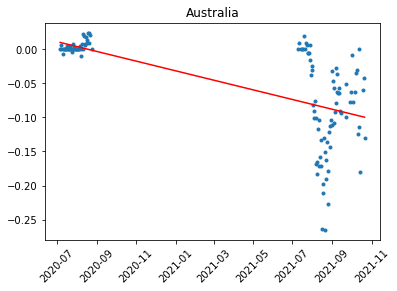

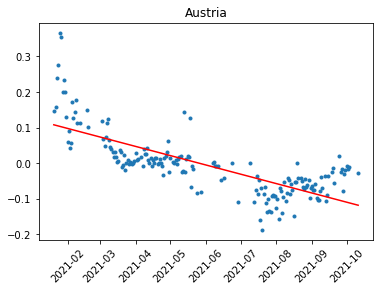

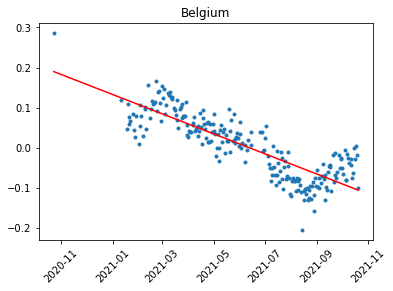

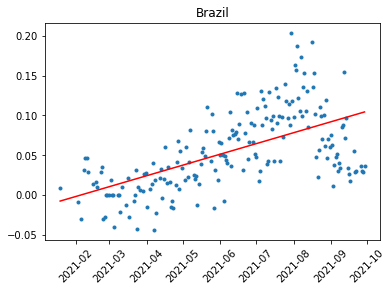

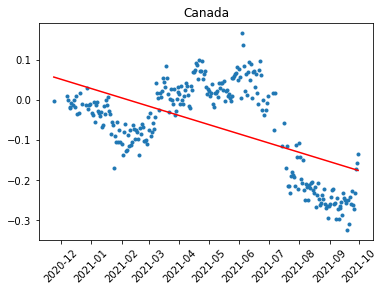

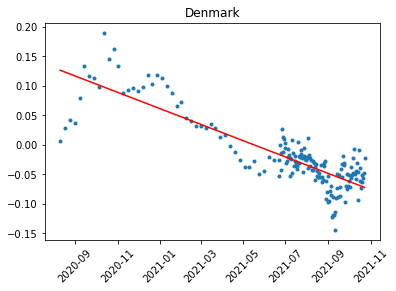

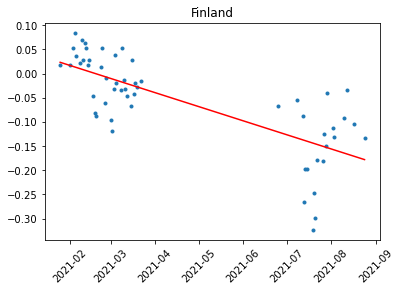

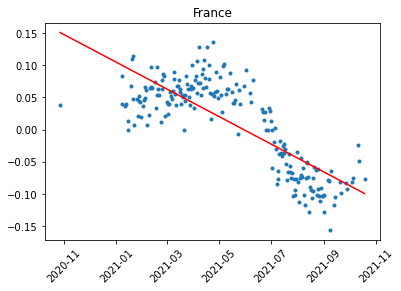

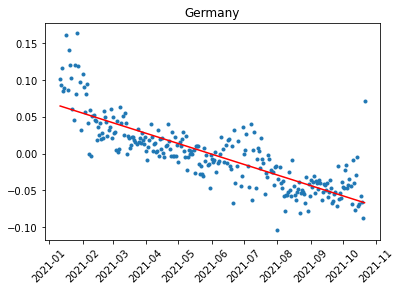

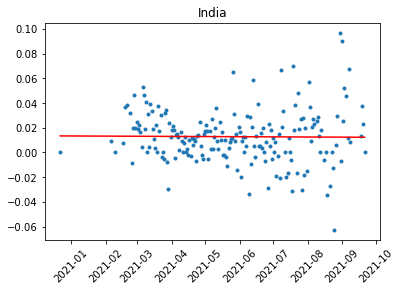

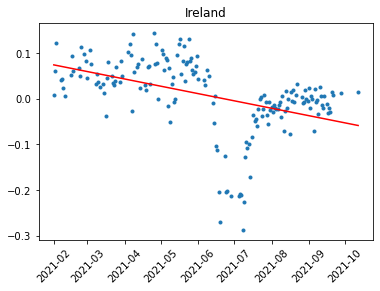

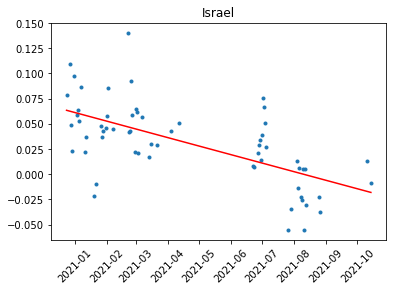

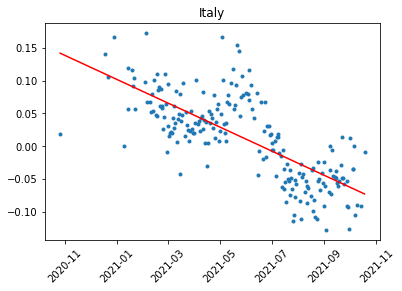

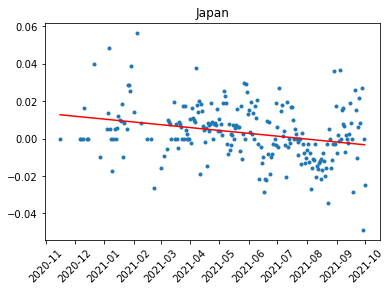

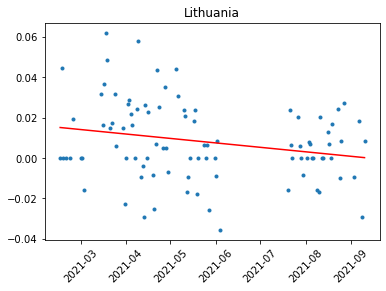

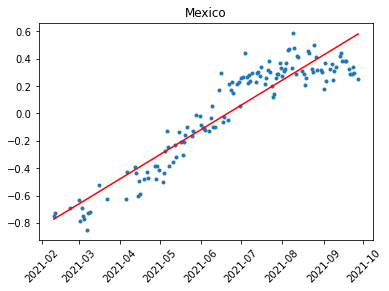

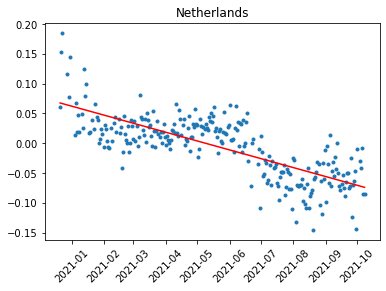

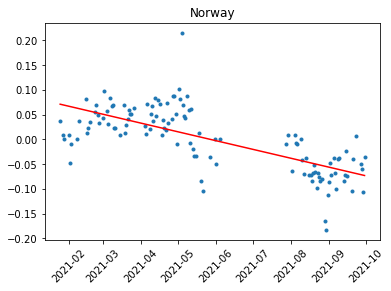

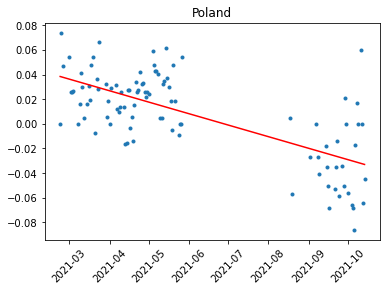

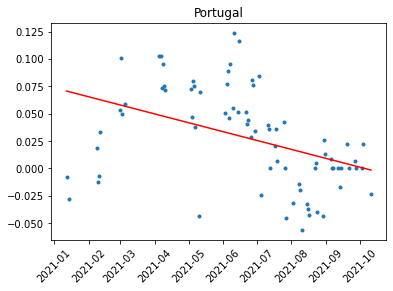

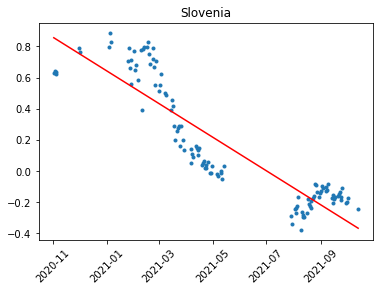

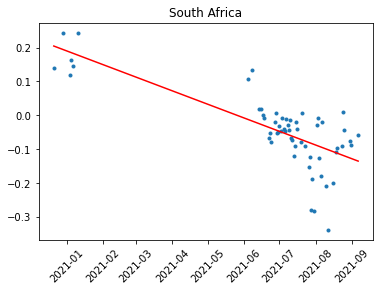

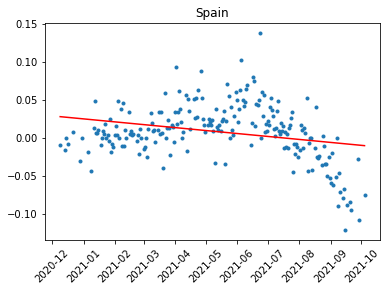

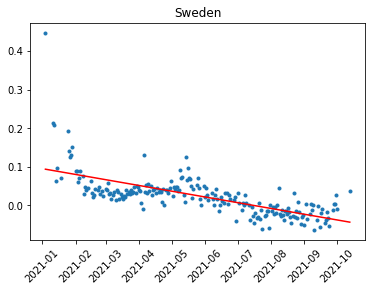

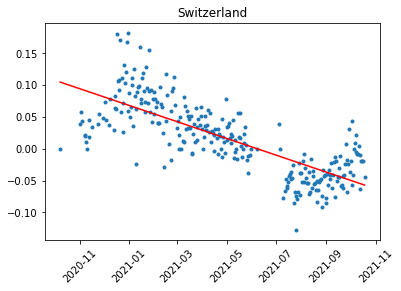

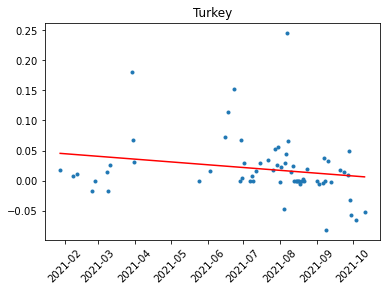

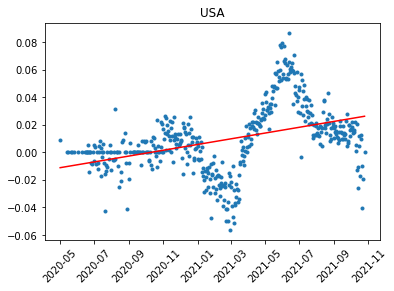

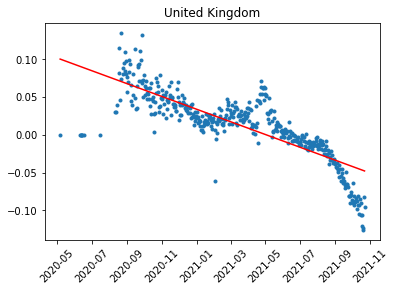

In [27]:
area_group: pd.DataFrame
# nth_group: pd.DataFrame
# for nth_comparison, nth_group in per_date_per_area.groupby("nth_comparison"):
area_slopes = []
for area, area_group in per_date_per_area.groupby("Area"):
    # for area, area_group in nth_group.groupby("Area"):
    if area_group["Date"].nunique() >= 30:
        captured_missed_diff = (
            area_group["AC_captured"] - area_group["AC_missed"]) / area_group["AC_total"]
        slope, intercept, r, p, se = stats.linregress(
            date2num(area_group["Date"].values), captured_missed_diff)
        plt.plot_date(
            area_group["Date"],
            captured_missed_diff,
            fmt="."
        )
        plt.plot(
            area_group["Date"],
            intercept + slope*date2num(area_group["Date"]),
            'r',
            label='fitted line'
        )
        plt.title(area)
        plt.xticks(rotation=45)
        plt.show()
        area_slopes.append(slope)


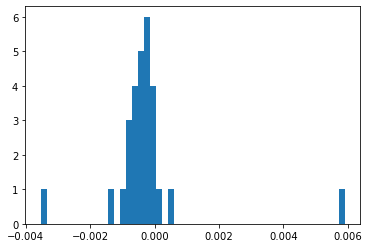

In [28]:
_ = plt.hist(area_slopes, bins=50)